## Deep Learning Approaches for RF-based detection & classification
Transfer learning with a fully connected layer

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models
import torchvision.transforms as transforms

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from file_paths import *

from nn_functions import runkfoldcv
import cv2

from models import *
# from torchsummary import summary

In [16]:
import importlib
import loading_functions
importlib.reload(loading_functions)
from loading_functions import *

### Load Features

In [17]:
feat_name = 'SPEC' # 'RAW' or 'PSD' or 'SPEC'
t_seg = 20
n_per_seg = 1024

output_name = 'drones'
feat_format = 'IMG'# ARR, IMG
which_dataset = 'dronerf'
output_tensor = True

# dataset specific parameters
drrf_highlow = 'L'
drde_ints = ['WIFI','CLEAN','BLUE','BOTH']

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, output_tensor, drrf_highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, output_tensor, drde_ints)

Loading DroneRF Dataset
Features_DroneRF/IMG_SPEC_L_1024_20/
dataset size 2640
shape of each item torch.Size([224, 224, 3])


In [18]:
print(dataset.__getitem__(100)[0].shape)
dataset.__getitem__(100)[0].dtype

torch.Size([224, 224, 3])


torch.float32

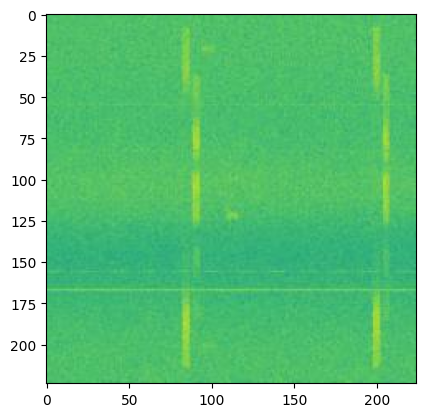

In [19]:
if feat_format =='IMG':
#      cv2.imshow()
    plt.imshow(dataset.__getitem__(90)[0])

In [20]:
dataset.__getitem__(100)[0][0].min()

tensor(0.2941)

## Run Model

In [21]:
num_classes = len(dataset.unique_labels)
which_model = 'vgg' # or 'resnet'
if which_model == 'vgg':
    Model = VGGFC(num_classes, isarray=(feat_format=='ARR'))
elif which_model == 'resnet':
    Model = ResNetFC(num_classes)
elif which_model == '1dconv':
    Model = RFUAVNet(num_classes)

c:\Users\Windows\Projects\GargoyleSystems\code\RFClassification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Windows\Projects\GargoyleSystems\code\RFClassification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
# test_samp = dataset.__getitem__(40)[0]
# test_samp = torch.unsqueeze(test_samp, 1)
# test_samp.shape

In [22]:
Model.isarray = False

In [23]:
test_samp = dataset.__getitem__(90)[0]
test_samp = torch.unsqueeze(test_samp, 0)
# test_samp = test_samp.repeat(1,3,1,1) 

Model(test_samp)

tensor([[0.2299, 0.1100, 0.0154, 0.0077]], grad_fn=<AddmmBackward0>)

In [56]:
# num_workers = 19
# train_val_test_split = [0.75, 0.05, 0.2]
# train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, (int(np.ceil(train_val_test_split[0]*len(dataset))), int(np.ceil(train_val_test_split[1]*len(dataset))), int(train_val_test_split[2]*len(dataset))))

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, num_workers=num_workers)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


In [24]:
# Configuration options
k_folds = 5

batch_size = 64 # 128
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:

trainedModel, res_acc, res_f1, res_runtime = runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=4, bias=True)
Starting epoch 1


KeyboardInterrupt: 

--------------------------------------------------------------------------------------------------------------